### Primary Objective:

#### Build a machine learning model that can accurately classify sonar signals as either rocks or mines with high precision and recall, particularly minimizing false negatives (missing actual mines).

In [1]:
import pandas as pd 
import numpy as np 
import re
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

#### Data Loading and Initial Exploration

In [13]:
df = pd.read_csv('rock_mine_data.csv', header=None)

In [14]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       208 non-null    float64
 1   1       208 non-null    float64
 2   2       208 non-null    float64
 3   3       208 non-null    float64
 4   4       208 non-null    float64
 5   5       208 non-null    float64
 6   6       208 non-null    float64
 7   7       208 non-null    float64
 8   8       208 non-null    float64
 9   9       208 non-null    float64
 10  10      208 non-null    float64
 11  11      208 non-null    float64
 12  12      208 non-null    float64
 13  13      208 non-null    float64
 14  14      208 non-null    float64
 15  15      208 non-null    float64
 16  16      208 non-null    float64
 17  17      208 non-null    float64
 18  18      208 non-null    float64
 19  19      208 non-null    float64
 20  20      208 non-null    float64
 21  21      208 non-null    float64
 22  22

(208, 61)

In [15]:
df.dtypes.value_counts()

float64    60
object      1
Name: count, dtype: int64

In [25]:
print("\nTarget Variable Distribution:")
print(df[60].value_counts())  # Replace 'target_column' with actual column name


Target Variable Distribution:
60
M    111
R     97
Name: count, dtype: int64


In [17]:
print("\nFirst 5 rows:")
df.head()


First 5 rows:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.4060,0.3973,0.2741,0.3690,0.5556,0.4846,0.3140,0.5334,0.5256,0.2520,0.2090,0.3559,0.6260,0.7340,0.6120,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.3210,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.5730,0.5399,0.3161,0.2285,0.6995,1.0000,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.2430,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.0230,0.0046,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [18]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
50    0
51    0
52    0
53    0
54    0
55    0
56    0
57    0
58    0
59    0
60    0
dtype: int64


#### Analyzing data distribution, patterns, and relationships

In [23]:
# Statistical summary
print("Statistical Summary:")
df.describe()


Statistical Summary:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,0.236013,0.250221,0.273305,0.296568,0.320201,0.378487,0.415983,0.452318,0.504812,0.563047,0.609060,0.624275,0.646975,0.672654,0.675424,0.699866,0.702155,0.694024,0.642074,0.580928,0.504475,0.439040,0.417220,0.403233,0.392571,0.384848,0.363807,0.339657,0.325800,0.311207,0.289252,0.278293,0.246542,0.214075,0.197232,0.160631,0.122453,0.091424,0.051929,0.020424,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,0.132705,0.140072,0.140962,0.164474,0.205427,0.232650,0.263677,0.261529,0.257988,0.262653,0.257818,0.255883,0.250175,0.239116,0.244926,0.237228,0.245657,0.237189,0.240250,0.220749,0.213992,0.213237,0.206513,0.231242,0.259132,0.264121,0.239912,0.212973,0.199075,0.178662,0.171111,0.168728,0.138993,0.133291,0.151628,0.133938,0.086953,0.062417,0.035954,0.013665,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,0.028900,0.023600,0.018400,0.027300,0.003100,0.016200,0.034900,0.037500,0.049400,0.065600,0.051200,0.021900,0.056300,0.023900,0.024000,0.092100,0.048100,0.028400,0.014400,0.061300,0.048200,0.040400,0.047700,0.021200,0.022300,0.008000,0.035100,0.038300,0.037100,0.011700,0.036000,0.005600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,0.129250,0.133475,0.166125,0.175175,0.164625,0.196300,0.205850,0.242075,0.299075,0.350625,0.399725,0.406925,0.450225,0.540725,0.525800,0.544175,0.531900,0.534775,0.463700,0.411400,0.345550,0.281400,0.257875,0.217575,0.179375,0.154350,0.160100,0.174275,0.173975,0.186450,0.163100,0.158900,0.155200,0.126875,0.094475,0.068550,0.064250,0.045125,0.026350,0.011550,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,0.224800,0.249050,0.263950,0.281100,0.281700,0.304700,0.308400,0.368300,0.434950,0.542500,0.617700,0.664900,0.699700,0.698500,0.721100,0.754500,0.745600,0.731900,0.680800,0.607150,0.490350,0.429600,0.391200,0.351050,0.312750,0.321150,0.306300,0.312700,0.283500,0.278050,0.259500,0.245100,0.222550,0.177700,0.148000,0.121350,0.101650,0.078100,0.044700,0.017900,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,0.301650,0.331250,0.351250,0.386175,0.452925,0.535725,0.659425,0.679050,0.731400,0.809325,0.816975,0.831975,0.848575,0.872175,0.873725,0.893800,0.917100,0.900275,0.852125,0.735175,0.641950,0.580300,0.556125,0.596125,0.593350,0.556525,0.518900,0.440550,0.434900,0.424350,0.387525,0.384250,0.324525,0.271750,0.231550,0.200375,0.154425,0.120100,0.0685

In [24]:
# Check for duplicate rows
df.duplicated().sum()


0

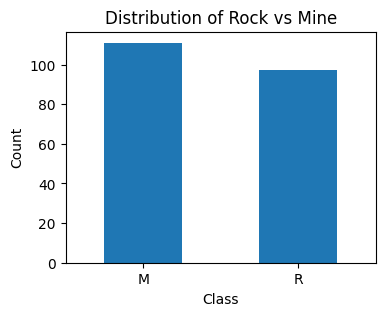

In [28]:
# Visualize target distribution
plt.figure(figsize=(4, 3))
df[60].value_counts().plot(kind='bar')
plt.title('Distribution of Rock vs Mine')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


In [30]:
df.groupby(60).mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
60,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
M,0.034989,0.045544,0.050720,0.064768,0.086715,0.111864,0.128359,0.149832,0.213492,0.251022,0.289581,0.301459,0.314426,0.320692,0.331182,0.380999,0.415007,0.455882,0.538062,0.617941,0.667426,0.672325,0.676701,0.689165,0.681204,0.706075,0.714754,0.712269,0.650283,0.581796,0.482378,0.428049,0.396577,0.36614,0.337553,0.318553,0.317034,0.331608,0.336365,0.305221,0.292594,0.300975,0.276883,0.248106,0.245225,0.198804,0.146917,0.110594,0.063708,0.022721,0.019352,0.016014,0.011643,0.012185,0.009923,0.008914,0.007825,0.009060,0.008695,0.006930
R,0.022498,0.030303,0.035951,0.041447,0.062028,0.096224,0.114180,0.117596,0.137392,0.159325,0.174713,0.191589,0.226249,0.268963,0.307636,0.375611,0.417100,0.448240,0.466762,0.500229,0.542270,0.569290,0.612959,0.653761,0.668809,0.692762,0.687737,0.673145,0.632680,0.579934,0.529762,0.451619,0.440841,0.44568,0.455530,0.460710,0.417330,0.348868,0.313709,0.318057,0.285428,0.252338,0.211822,0.175132,0.142312,0.116949,0.094458,0.069488,0.038449,0.017796,0.012311,0.010453,0.009640,0.009518,0.008567,0.007430,0.007814,0.006677,0.007078,0.006024


####  Encode target variable if it's categorical (Rock/Mine -> 0/1)

In [31]:
if df[60].dtype == 'object':
    label_encoder = LabelEncoder()
    df[60] = label_encoder.fit_transform(df[60])
    print("Target encoding:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

print(f"Final dataset shape: {df.shape}")

Target encoding: {'M': 0, 'R': 1}
Final dataset shape: (208, 61)


####  Separating input features (X) from target variable (y)

In [33]:
# Separate features and target
X = df.drop(60, axis=1)  # Replace with actual target column name
y = df[60]

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Display feature names
print(f"\nFeatures: {list(X.columns)}")

Feature matrix shape: (208, 60)
Target vector shape: (208,)

Features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]


#### Splitting data into training and testing sets

In [34]:
# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.1, 
    random_state=42, 
    stratify=y  # Ensures balanced distribution in both sets
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Check class distribution in both sets
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

Training set size: 187 samples
Test set size: 21 samples

Training set class distribution:
60
0    100
1     87
Name: count, dtype: int64

Test set class distribution:
60
0    11
1    10
Name: count, dtype: int64


In [39]:
print("Training features mean before scaling:\n", X_train.mean())
print("\nTraining features std before scaling:\n", X_train.std())


Training features mean before scaling:
 0     0.029548
1     0.038296
2     0.043919
3     0.053399
4     0.075263
5     0.105613
6     0.124083
7     0.136378
8     0.179920
9     0.210009
10    0.238772
11    0.251356
12    0.274025
13    0.297984
14    0.323882
15    0.388131
16    0.428793
17    0.461575
18    0.515994
19    0.568333
20    0.611898
21    0.623533
22    0.646870
23    0.671341
24    0.670805
25    0.695140
26    0.695707
27    0.686323
28    0.635432
29    0.578072
30    0.502058
31    0.441318
32    0.424134
33    0.414109
34    0.403454
35    0.390019
36    0.370123
37    0.344493
38    0.324433
39    0.311651
40    0.293243
41    0.281019
42    0.245767
43    0.217399
44    0.201747
45    0.164206
46    0.124672
47    0.093201
48    0.052565
49    0.020479
50    0.015817
51    0.013291
52    0.010453
53    0.010850
54    0.009452
55    0.008359
56    0.007969
57    0.008106
58    0.008073
59    0.006529
dtype: float64

Training features std before scaling:
 0    

#### Standardizing feature values to have mean=0 and std=1

In [40]:
# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed")
print(f"Training features mean after scaling: {X_train_scaled.mean():.6f}")
print(f"Training features std after scaling: {X_train_scaled.std():.6f}")

Feature scaling completed
Training features mean after scaling: 0.000000
Training features std after scaling: 1.000000


#### Training the logistic regression model

In [43]:
# Initialize and train the logistic regression model
log_reg = LogisticRegression(
    random_state=42,
    max_iter=1000,  # Increase if convergence warning appears
    solver='liblinear'  # Good for small datasets
)

# Train the model
log_reg.fit(X_train_scaled, y_train)

print("Model training completed")
print(f"Model coefficients shape: {log_reg.coef_.shape}")
print(f"Model intercept: {log_reg.intercept_}")

Model training completed
Model coefficients shape: (1, 60)
Model intercept: [-0.67749899]


In [44]:
print(log_reg)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')


#### Making predictions and evaluating model performance

In [45]:
# Make predictions
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

# Get prediction probabilities
y_test_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

Training Accuracy: 0.9091
Test Accuracy: 0.8571

Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        11
           1       1.00      0.70      0.82        10

    accuracy                           0.86        21
   macro avg       0.89      0.85      0.85        21
weighted avg       0.89      0.86      0.85        21



#### Confusion Matrix Analysis

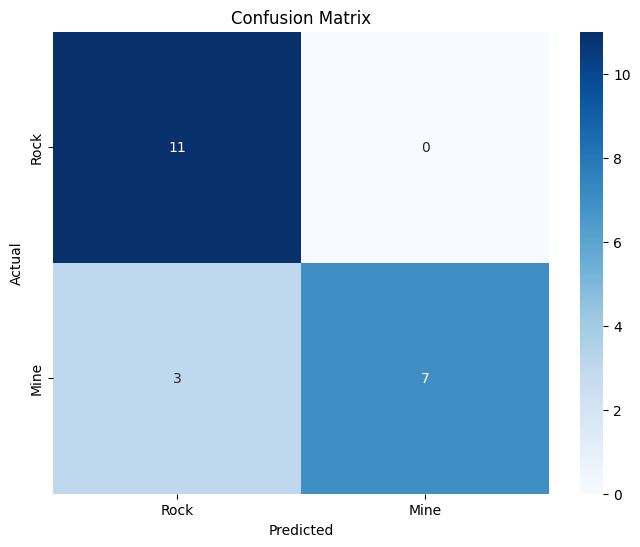


Confusion Matrix Analysis:
True Negatives (Rock correctly predicted): 11
False Positives (Rock predicted as Mine): 0
False Negatives (Mine predicted as Rock): 3
True Positives (Mine correctly predicted): 7

Manual Calculations:
Precision: 1.0000
Recall: 0.7000
F1-Score: 0.8235


In [46]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Rock', 'Mine'], 
            yticklabels=['Rock', 'Mine'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Analysis:")
print(f"True Negatives (Rock correctly predicted): {tn}")
print(f"False Positives (Rock predicted as Mine): {fp}")
print(f"False Negatives (Mine predicted as Rock): {fn}")
print(f"True Positives (Mine correctly predicted): {tp}")

# Calculate additional metrics
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"\nManual Calculations:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

#### ROC-AUC helps evaluate model performance across different thresholds

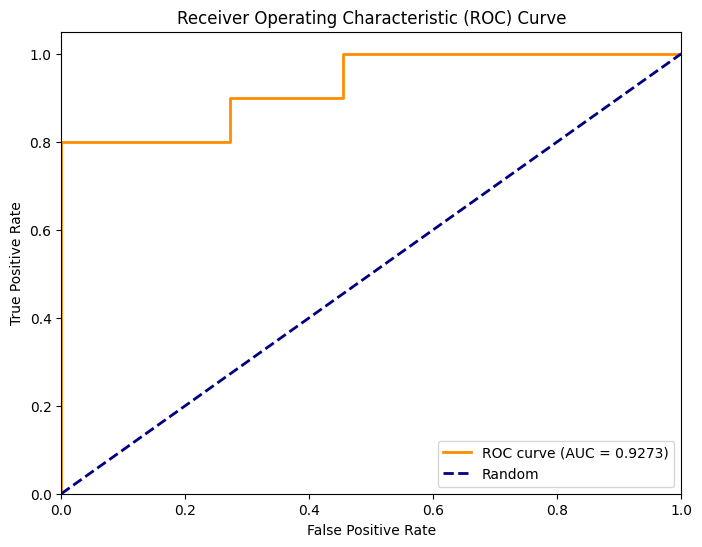

AUC Score: 0.9273


In [47]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC Score: {roc_auc:.4f}")

The Receiver Operating Characteristic (ROC) curve provides a visual evaluation of the classifier's performance in distinguishing between the two classes. In this analysis, the ROC curve bows significantly toward the top-left corner, indicating strong discriminative power. The model achieved an Area Under the Curve (AUC) score of 0.9273, which reflects excellent classification capability. This high AUC value means the model is able to correctly differentiate between positive and negative instances with a high degree of accuracy. Compared to the random classifier baseline, represented by the diagonal dashed line, our model performs significantly better across various classification thresholds. This confirms the robustness and reliability of the trained classifier for the given dataset.

#### Performing k-fold cross-validation

In [50]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=9, scoring='accuracy')

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

# Cross-validation with different metrics
cv_precision = cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring='precision')
cv_recall = cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring='recall')

print(f"\nCross-Validation Precision: {cv_precision.mean():.4f} (+/- {cv_precision.std() * 2:.4f})")
print(f"Cross-Validation Recall: {cv_recall.mean():.4f} (+/- {cv_recall.std() * 2:.4f})")

Cross-Validation Scores: [0.9047619  0.61904762 0.9047619  0.80952381 0.85714286 0.66666667
 0.71428571 0.6        0.9       ]
Mean CV Score: 0.7751
Standard Deviation: 0.1191

Cross-Validation Precision: 0.7346 (+/- 0.1291)
Cross-Validation Recall: 0.7562 (+/- 0.2187)


#### Hyperparameter Tuning 

In [51]:
# Define hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga', 'lbfgs']
}

# Perform grid search
grid_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

# Evaluate best model on test set
best_model = grid_search.best_estimator_
y_test_pred_best = best_model.predict(X_test_scaled)
test_accuracy_best = accuracy_score(y_test, y_test_pred_best)

print(f"Test Accuracy with Best Model: {test_accuracy_best:.4f}")

Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Best Cross-Validation Score: 0.7694
Test Accuracy with Best Model: 0.8571


#### Feature Importance Analysis

Top 10 Most Important Features:
    feature  coefficient  abs_coefficient
30       30     1.445967         1.445967
36       36     1.258392         1.258392
48       48    -1.048822         1.048822
49       49     1.022921         1.022921
11       11    -1.011773         1.011773
2         2     0.985315         0.985315
3         3    -0.840603         0.840603
8         8    -0.815308         0.815308
39       39     0.784310         0.784310
0         0    -0.744947         0.744947


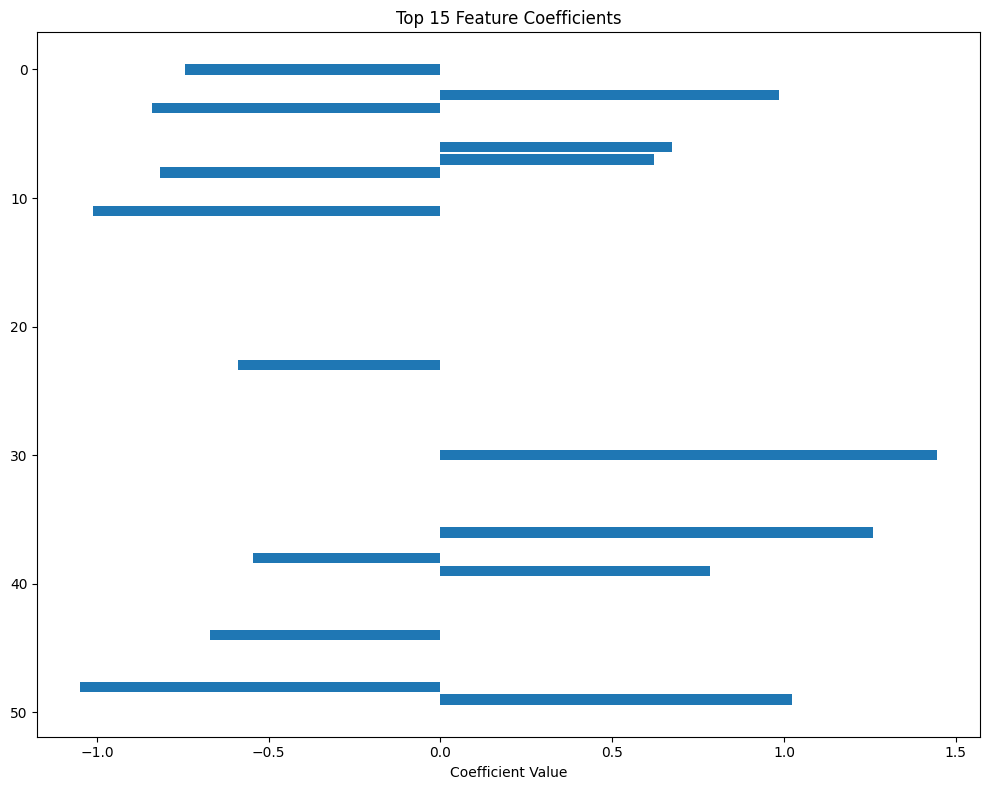

In [52]:
# Get feature coefficients
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': log_reg.coef_[0],
    'abs_coefficient': np.abs(log_reg.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(top_features['feature'], top_features['coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top 15 Feature Coefficients')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [53]:
# Model summary
print("=== MODEL PERFORMANCE SUMMARY ===")
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"AUC Score: {roc_auc:.4f}")
print(f"Cross-Validation Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Performance interpretation
if test_accuracy > 0.85:
    print("✓ Excellent model performance!")
elif test_accuracy > 0.75:
    print("✓ Good model performance")
elif test_accuracy > 0.65:
    print("⚠ Moderate model performance - consider feature engineering")
else:
    print("✗ Poor model performance - needs significant improvement")

# Business insights
print(f"\n=== BUSINESS INSIGHTS ===")
print(f"• Model correctly identifies {recall:.1%} of actual mines (Recall)")
print(f"• {precision:.1%} of mine predictions are correct (Precision)")
print(f"• False Negative Rate: {fn/(fn+tp):.1%} (Missing actual mines)")
print(f"• False Positive Rate: {fp/(fp+tn):.1%} (False alarms)")

=== MODEL PERFORMANCE SUMMARY ===
Final Test Accuracy: 0.8571
AUC Score: 0.9273
Cross-Validation Score: 0.7751 (+/- 0.2381)
✓ Excellent model performance!

=== BUSINESS INSIGHTS ===
• Model correctly identifies 70.0% of actual mines (Recall)
• 100.0% of mine predictions are correct (Precision)
• False Negative Rate: 30.0% (Missing actual mines)
• False Positive Rate: 0.0% (False alarms)


#### Model Saving and Deployment Preparation

In [71]:
import joblib

# Save the model and scaler
joblib.dump(log_reg, 'rock_mine_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')

print("Model and scaler saved successfully!")

# Example of how to load and use the model later
def predict_new_sample(new_data):
    """
    Function to predict on new data
    new_data: array-like or DataFrame with same features as training data
    """
    # Load saved components
    loaded_model = joblib.load('rock_mine_model.pkl')
    loaded_scaler = joblib.load('feature_scaler.pkl')
    
    # Scale the new data
    new_data_scaled = loaded_scaler.transform(new_data)
    
    # Make prediction
    prediction = loaded_model.predict(new_data_scaled)
    probability = loaded_model.predict_proba(new_data_scaled)
    
    return prediction, probability

print("Prediction function created for future use")

Model and scaler saved successfully!
Prediction function created for future use


In [86]:
test = np.asarray(df.iloc[172:178, :60])
predict_new_sample(test)


(array([0, 0, 0, 0, 0, 0]),
 array([[8.56219202e-01, 1.43780798e-01],
        [6.50613719e-01, 3.49386281e-01],
        [9.99742940e-01, 2.57060102e-04],
        [9.97042224e-01, 2.95777570e-03],
        [9.98684559e-01, 1.31544104e-03],
        [5.57933170e-01, 4.42066830e-01]]))